# Explore the comoving pair data from Semyeong Oh

First, load Semyeong's catalogues of low-confidence comoving pairs.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline
import pyfits
from astropy.table import Table

In [3]:
star1 = pd.read_csv("star1_kic_1.csv")
star2 = pd.read_csv("star2_kic_1.csv")

Load Semyeong's original file:

In [4]:
hdulist = pyfits.open("pairindices_cp1.fits")
t = hdulist[1].data
m1 = t["star1"]  # indices in the stacked_tgas.fits file
m2 = t["star2"]

Check that these catalogues match up...

In [5]:
table = Table.read('stacked_tgas.fits')
stacked_tgas_df = table.to_pandas()
star1_df = stacked_tgas_df.iloc[m1]
star2_df = stacked_tgas_df.iloc[m2]

Load Kepler-TGAS cross-matched table

In [6]:
kplr_tgas = pd.read_csv("kic_tgas_mod.csv")

In [7]:
m_tgas = star1_df.source_id.isin(kplr_tgas.source_id).values * \
        star2_df.source_id.isin(kplr_tgas.source_id).values
star1_tgas = star1_df.iloc[np.where(m_tgas)[0]]
star2_tgas = star2_df.iloc[np.where(m_tgas)[0]]

In [8]:
print(star1_tgas.source_id.values[0], star2_tgas.source_id.values[0])

2049135390918975360 2076482237961592960


Check these match up in Semyeong's original file.

In [9]:
print(star1_df.source_id.values[star1_df.source_id.values == star1_tgas.source_id.values[0]])
print(star2_df.source_id.values[star2_df.source_id.values == star2_tgas.source_id.values[0]])

[2049135390918975360 2049135390918975360]
[2076482237961592960 2076482237961592960 2076482237961592960
 2076482237961592960]


This looks right. The reason they are repeated is because these stars are comoving with more than one other star. So star1_kic_1.csv and star2_kic_1.csv are good files to use.

# Plotting rotation periods for the pairs.

Take the first pair in the set and look at their rotation periods.

In [10]:
import rotation as rot

In [11]:
kepid1, kepid2 = star1.kepid.values[0], star2.kepid.values[0]
print(kepid1, kepid2)

3459226 4935189


In [12]:
s1 = rot.prot(kepid1)
s2 = rot.prot(kepid2)

Loading light curve...
Loading light curve...


In [13]:
print(s1.pgram_ps())

Calculating periodogram
(16.700000000000003, 5.4065775103851105e-09)


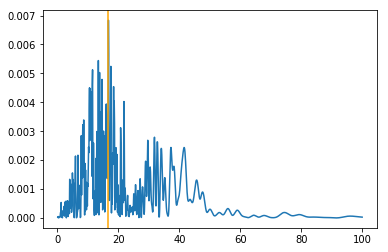

In [14]:
pl.plot(s1.ps, s1.pgram)
pl.axvline(s1.pgram_period, color="orange")

Calculating periodogram
(26.200000000000003, 3.951025835962456e-05)


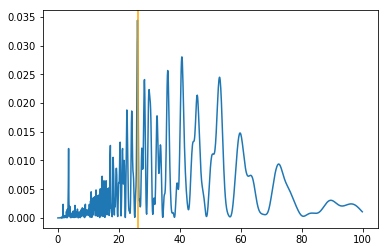

In [15]:
print(s2.pgram_ps())
pl.plot(s2.ps, s2.pgram)
pl.axvline(s2.pgram_period, color="orange")

Calculate the stars' ages from their rotation periods. First calculate their B-V colours.

In [16]:
import teff_bv as tbv
bv1 = tbv.teff2bv(star1.teff.values, star1.logg.values, star1.feh.values)
bv2 = tbv.teff2bv(star2.teff.values, star2.logg.values, star2.feh.values)

Then calculate their ages using simple gyrochronology.

In [17]:
from make_gyro_plots import calculate_gyrochronal_ages as gyro

In [18]:
c = .45
par = [.4, .31, c, .55]
age1 = gyro(par, s1.pgram_period, bv1[0])
age2 = gyro(par, s2.pgram_period, bv2[0])
print(bv1[0], bv2[0])
print(age1, age2)

0.280574815242 0.504405578756
nan 10.3489013224


/Users/ruthangus/projects/teacups/teacups/make_gyro_plots.py:34: RuntimeWarning: invalid value encountered in double_scalars
  return (period / (a*(bv - c)**b))**(1./n) * 1e-3


And their van Saders ages...

In [27]:
from vansaders_age import age
print("teff = ", star1.teff.values[0], "period = ", s1.pgram_period, "age = ", 
      age([star1.teff.values[0], s1.pgram_period]))
print("teff = ", star2.teff.values[0], "period = ", s2.pgram_period, "age = ", 
      age([star2.teff.values[0], s2.pgram_period]))

teff =  7360 period =  10.1 age =  1.01341228
teff =  6256 period =  26.2 age =  3.9614204


That is *way* better!

Okay that first star is too massive for gyrochronology, let's try the second pair.

In [30]:
i = 1
s1 = rot.prot(star1.kepid.values[i])
s2 = rot.prot(star2.kepid.values[i])
s1.pgram_ps()
s2.pgram_ps()

Loading light curve...
Loading light curve...
Calculating periodogram
Calculating periodogram


(26.200000000000003, 3.951025835962456e-05)

In [31]:
age1 = age([star1.teff.values[i], s1.pgram_period])
age2 = age([star2.teff.values[i], s2.pgram_period])
print(age1, age2)

2.54902971 3.9614204


These aren't bad... Let's write a function and check a few more...

In [35]:
def pair_ages(i):
    s1 = rot.prot(star1.kepid.values[i])
    s2 = rot.prot(star2.kepid.values[i])
    s1.pgram_ps()
    s2.pgram_ps()
    age1 = age([star1.teff.values[i], s1.pgram_period])
    age2 = age([star2.teff.values[i], s2.pgram_period])
    return age1, age2

In [37]:
print("ages = ", pair_ages(2), "Gyr")
print("ages = ", pair_ages(3), "Gyr")

Loading light curve...
Loading light curve...
Calculating periodogram
Calculating periodogram
ages =  (1.086652583545848, 0.5505383033551261) Gyr
Loading light curve...
Loading light curve...
Calculating periodogram
Calculating periodogram
ages =  (nan, 0.24673606464374348) Gyr


/Users/ruthangus/projects/teacups/teacups/make_gyro_plots.py:34: RuntimeWarning: invalid value encountered in double_scalars
  return (period / (a*(bv - c)**b))**(1./n) * 1e-3


# Get all rotation periods

In [1]:
p1s, p2s = [], []
for kepid1, i in enumerate(star1.kepid.values):
    
    # Set up the rotation objects
    s1 = rot.prot(star1.kepid.values[i])
    s2 = rot.prot(star2.kepid.values[i])
    
    # Calculate the filtered periodograms.
    s1.pgram_ps()
    s2.pgram_ps()
    
    # Get the periods
    p1 = s1.pgram_period
    p2 = s2.pgram_period
    
    # plot the light curve and the periodogram.
    plt.subplot(2, 1, 1)
    plt.plot(s1.x, s1.y, "k.")
    plt.subplot(2, 1, 2)
    plt.plot(s1.ps, s1.pgram)
    plt.axvline(s2.pgram_period, color="orange")
    
    # Save the periods.
    p1s.append(p1)
    p2s.append(p2)
    
    input("enter")

NameError: name 'star1' is not defined

What I need to do next is:
1. Get GP periods running on BBQ.
2. Get RVs for MDM targets.
3. Identify the true pairs from the list in MDM.
4. Look at the pairs identified by Janes.
5. Maybe try to repeat Janes.
6. Look at stars in the K2 fields too.
7. Could always repeat the Janes paper in a better way.
8. Look at the groups, not just the pairs.